In [1]:
import os
import torch

# GPU 2를 사용하도록 환경 변수 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 현재 사용 중인 GPU ID 확인
current_device = torch.cuda.current_device()
print(f"Current CUDA device: {current_device}")

# 현재 사용 중인 GPU 이름 확인
current_device_name = torch.cuda.get_device_name(current_device)
print(f"Current CUDA device name: {current_device_name}")

# 실제로 설정된 환경 변수를 확인
print(f"CUDA_VISIBLE_DEVICES: {os.environ.get('CUDA_VISIBLE_DEVICES')}")

Using device: cuda
Current CUDA device: 0
Current CUDA device name: NVIDIA RTX A5000
CUDA_VISIBLE_DEVICES: 2


In [19]:
import cv2
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [20]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [21]:
def image_to_patches(image, patch_size=512): # 이미지를 패치로 나누는 함수
    patches = []
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue  # Skip patches that are smaller than patch_size
            patches.append(patch)
    return patches

class SatelliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir, patch_size=512, transform=None, infer=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.infer = infer
        self.patch_size = patch_size
        self.image_files = sorted(os.listdir(image_dir)) # 이미지 파일 목록 정렬
        self.mask_files = sorted(os.listdir(mask_dir)) # 마스크 파일 목록 정렬

    def __len__(self):
        num_patches_per_image = (1920 // self.patch_size) ** 2
        return len(self.image_files) * num_patches_per_image  # 전체 데이터를 사용

    def __getitem__(self, idx):
        num_patches_per_image = (1920 // self.patch_size) ** 2 # 이미지당 패치 수
        img_idx = idx // num_patches_per_image # 이미지 인덱스
        patch_idx = idx % num_patches_per_image

        img_path = os.path.join(self.image_dir, self.image_files[img_idx]) # 이미지 경로
        mask_path = os.path.join(self.mask_dir, self.mask_files[img_idx])

        image = cv2.imread(img_path) # 이미지 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 채널 변경

        if self.infer: # 추론 시, 사실상 test dataset이 없으므로 없는 코드 
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 이미지와 마스크를 패치로 나누기
        image_patches = image_to_patches(image, self.patch_size)
        mask_patches = image_to_patches(mask, self.patch_size)

        image = image_patches[patch_idx] # 이미지 패치
        mask = mask_patches[patch_idx]

        if self.transform: # 각 epoch마다 getitem을 통해 이미지와 마스크를 변환
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# 데이터 증강 파이프라인 설정 (훈련용)
train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5), # 50% 확률로 좌우 반전
        A.VerticalFlip(p=0.5), # 50% 확률로 상하 반전
        A.RandomRotate90(p=0.5), # 50% 확률로 90도 회전
        A.RandomBrightnessContrast(p=0.2),
        A.GaussNoise(p=0.1),
        A.GaussianBlur(p=0.1),
        A.RandomBrightnessContrast(p=0.1),
        # A.GridDistortion(p=0.1),
        # A.OpticalDistortion(p=0.1),
        # A.RandomShadow(p=0.1),
        A.Normalize(),
        ToTensorV2()
    ]
)

# 데이터 증강 파이프라인 설정 (검증용)
val_transform = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ]
)
# 데이터셋 인스턴스 생성
image_dir = './buildings/train_images'
mask_dir = './buildings/train_masks'

full_dataset = SatelliteDataset(image_dir=image_dir, mask_dir=mask_dir, patch_size=384, transform=None)

# 데이터셋을 train과 validation으로 분할
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size


# 랜덤 시드 설정
set_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 각각의 데이터셋에 대해 다른 변환 적용
train_dataset = Subset(SatelliteDataset(image_dir=image_dir, mask_dir=mask_dir, 
                                        patch_size=384, transform=train_transform), train_dataset.indices)

val_dataset = Subset(SatelliteDataset(image_dir=image_dir, mask_dir=mask_dir, 
                                      patch_size=384, transform=val_transform), val_dataset.indices)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=4)

# 데이터셋 길이 확인
print(len(full_dataset))

# 데이터셋 길이 확인
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

1000
Train dataset length: 800
Validation dataset length: 200


torch.Size([3, 384, 384]) torch.Size([384, 384])


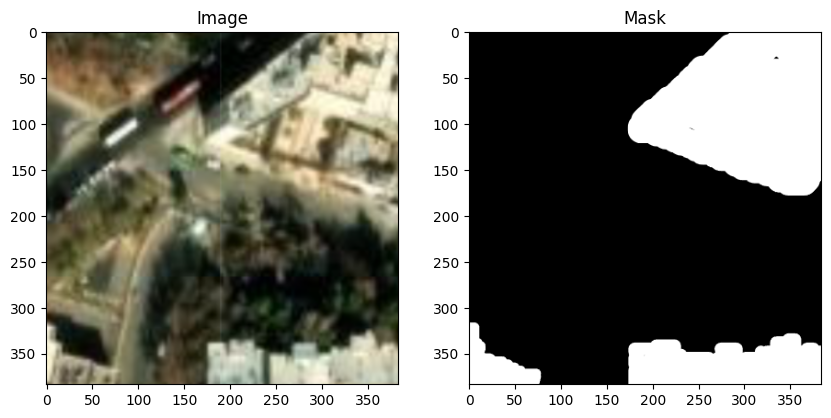

In [22]:

# 데이터 포인트 확인
image, mask = val_dataset[1]
print(image.shape, mask.shape)

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# 이미지와 마스크를 시각화하는 함수
def visualize_sample(image, mask, mean, std):
    image = denormalize(image, mean, std)
    image = image.permute(1, 2, 0).cpu().numpy()  # 채널을 마지막으로 배치하고 numpy 배열로 변환
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)  # 역정규화된 이미지를 시각화
    ax[0].set_title('Image')
    ax[1].imshow(mask.cpu().numpy(), cmap='gray')
    ax[1].set_title('Mask')
    plt.show()

# 시각화
visualize_sample(image, mask, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [25]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # Sigmoid activation to get probability
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return bce_loss + dice_loss
    
def dice_score(inputs, targets, smooth=1):
    inputs = torch.sigmoid(inputs)  # Sigmoid activation to get probability
    inputs = (inputs > 0.5).float()  # Binarize the outputs at 0.5 threshold
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return dice.item()

In [26]:
import segmentation_models_pytorch as smp
# hyper parameters 
epoch_num = 50
learning_rate = 0.001
# patience = 4 # patience 횟수 동안 validation loss가 개선되지 않으면 학습을 조기 중지
# early_stopping_counter = 5 # counter동안 validation loss가 개선되지 않으면 학습을 조기 중지
best_val_loss = float('inf')

# model 초기화 
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)
# model = UNetWithResnet50Encoder().to(device)

# loss function과 optimizer 정의
criterion = BCEDiceLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-05, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# 손실 기록을 위한 리스트
train_losses = []
val_losses = []

best_epoch = 0
# training loop
for epoch in range(epoch_num):  # 30 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.float().to(device) # 이미지와 마스크를 GPU로 이동
        masks = masks.float().to(device)
        masks = masks / 255  # 마스크를 0과 1로 변환

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    train_losses.append(epoch_loss / len(train_loader)) # training loss 기록
    print(f'Train Epoch {epoch+1}, Loss: {train_losses[-1]}')
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        epoch_val_dice = 0
        for images, masks in tqdm(val_loader):
            images = images.float().to(device) # 이미지와 마스크를 GPU로 이동
            masks = masks.float().to(device)
            masks = masks / 255  # 마스크를 0과 1로 변환

            outputs = model(images)
            val_loss = criterion(outputs, masks.unsqueeze(1))
            epoch_val_loss += val_loss.item()
            epoch_val_dice += dice_score(outputs, masks.unsqueeze(1))

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss) # validation loss 기록
        avg_val_dice = epoch_val_dice / len(val_loader)
        print(f'Val Epoch {epoch+1}, Loss: {avg_val_loss}, Dice Score: {avg_val_dice}')


        
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate for Epoch {epoch+1}: {current_lr}')

        # Save the best model and apply early stopping
        if avg_val_loss < best_val_loss: 
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pt') # validation loss가 감소하면 모델을 저장
            best_epoch = epoch + 1
            print("best epoch: ", best_epoch)
            # early_stopping_counter = 0  # Reset counter
        # else:
        #     early_stopping_counter += 1  # Increment counter
        #     if early_stopping_counter >= patience:
        #         print("Early stopping, best epoch: ", best_epoch)
        #         break
print("Training finished!, best epoch: ", best_epoch)

100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Train Epoch 1, Loss: 0.7349541433155536


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Val Epoch 1, Loss: 0.548895925283432, Dice Score: 0.7640516042709351
Learning Rate for Epoch 1: 0.0009990133642141358
best epoch:  1


100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Train Epoch 2, Loss: 0.4553011119365692


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 2, Loss: 0.5075448006391525, Dice Score: 0.7813561499118805
Learning Rate for Epoch 2: 0.000996057350657239
best epoch:  2


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 3, Loss: 0.40009495094418523


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 3, Loss: 0.4708427876234055, Dice Score: 0.8100117921829224
Learning Rate for Epoch 3: 0.0009911436253643444
best epoch:  3


100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


Train Epoch 4, Loss: 0.36258974820375445


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 4, Loss: 0.4494446456432343, Dice Score: 0.8173599779605866
Learning Rate for Epoch 4: 0.0009842915805643156
best epoch:  4


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 5, Loss: 0.3484974272549152


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Val Epoch 5, Loss: 0.38832005560398103, Dice Score: 0.8403534352779388
Learning Rate for Epoch 5: 0.0009755282581475769
best epoch:  5


100%|██████████| 40/40 [00:20<00:00,  1.92it/s]


Train Epoch 6, Loss: 0.3023450404405594


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Val Epoch 6, Loss: 0.3532603055238724, Dice Score: 0.85305837392807
Learning Rate for Epoch 6: 0.0009648882429441258
best epoch:  6


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 7, Loss: 0.30644673854112625


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Val Epoch 7, Loss: 0.3391100883483887, Dice Score: 0.8601383328437805
Learning Rate for Epoch 7: 0.0009524135262330099
best epoch:  7


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 8, Loss: 0.2914106100797653


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Val Epoch 8, Loss: 0.3276224255561829, Dice Score: 0.8606278121471405
Learning Rate for Epoch 8: 0.0009381533400219318
best epoch:  8


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 9, Loss: 0.2538142781704664


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 9, Loss: 0.2794903337955475, Dice Score: 0.8850562691688537
Learning Rate for Epoch 9: 0.0009221639627510075
best epoch:  9


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 10, Loss: 0.2319940712302923


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 10, Loss: 0.28777207136154176, Dice Score: 0.881060254573822
Learning Rate for Epoch 10: 0.0009045084971874736


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 11, Loss: 0.24084235578775406


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Val Epoch 11, Loss: 0.3199774295091629, Dice Score: 0.8705706298351288
Learning Rate for Epoch 11: 0.0008852566213878945


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 12, Loss: 0.22967444993555547


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 12, Loss: 0.32090056836605074, Dice Score: 0.8724199712276459
Learning Rate for Epoch 12: 0.0008644843137107056


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 13, Loss: 0.22692790515720845


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Val Epoch 13, Loss: 0.25871080458164214, Dice Score: 0.8934317231178284
Learning Rate for Epoch 13: 0.0008422735529643443
best epoch:  13


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 14, Loss: 0.2374867431819439


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 14, Loss: 0.27528021931648256, Dice Score: 0.8906718254089355
Learning Rate for Epoch 14: 0.0008187119948743448


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 15, Loss: 0.21445508673787117


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 15, Loss: 0.2979997545480728, Dice Score: 0.8717908561229706
Learning Rate for Epoch 15: 0.0007938926261462366


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 16, Loss: 0.2097293734550476


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 16, Loss: 0.29470684081315995, Dice Score: 0.8814182817935944
Learning Rate for Epoch 16: 0.0007679133974894982


100%|██████████| 40/40 [00:20<00:00,  1.92it/s]


Train Epoch 17, Loss: 0.181633872538805


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 17, Loss: 0.2661256343126297, Dice Score: 0.8902408480644226
Learning Rate for Epoch 17: 0.0007408768370508576


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 18, Loss: 0.17270753644406794


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 18, Loss: 0.2376360535621643, Dice Score: 0.9046076834201813
Learning Rate for Epoch 18: 0.0007128896457825362
best epoch:  18


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 19, Loss: 0.16530426703393458


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 19, Loss: 0.26635426431894305, Dice Score: 0.8911335349082947
Learning Rate for Epoch 19: 0.0006840622763423389


100%|██████████| 40/40 [00:21<00:00,  1.90it/s]


Train Epoch 20, Loss: 0.16145722158253192


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 20, Loss: 0.24192140400409698, Dice Score: 0.9033740103244782
Learning Rate for Epoch 20: 0.0006545084971874735


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 21, Loss: 0.1579731734469533


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 21, Loss: 0.22497750371694564, Dice Score: 0.9080905735492706
Learning Rate for Epoch 21: 0.0006243449435824271
best epoch:  21


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 22, Loss: 0.14754125587642192


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 22, Loss: 0.22651279121637344, Dice Score: 0.9093521177768707
Learning Rate for Epoch 22: 0.0005936906572928622


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 23, Loss: 0.14467970058321952


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 23, Loss: 0.22694221585989, Dice Score: 0.9080610752105713
Learning Rate for Epoch 23: 0.000562666616782152


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 24, Loss: 0.13029988519847394


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 24, Loss: 0.21826985627412795, Dice Score: 0.9125423014163971
Learning Rate for Epoch 24: 0.0005313952597646566
best epoch:  24


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 25, Loss: 0.13719972856342794


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 25, Loss: 0.23611560612916946, Dice Score: 0.9054921746253968
Learning Rate for Epoch 25: 0.0004999999999999998


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 26, Loss: 0.1278475871309638


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 26, Loss: 0.23971977531909944, Dice Score: 0.9038002192974091
Learning Rate for Epoch 26: 0.00046860474023534314


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 27, Loss: 0.12441785037517547


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 27, Loss: 0.2358589768409729, Dice Score: 0.9074632704257966
Learning Rate for Epoch 27: 0.00043733338321784774


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 28, Loss: 0.11995154805481434


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 28, Loss: 0.23029299974441528, Dice Score: 0.9103372752666473
Learning Rate for Epoch 28: 0.00040630934270713756


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 29, Loss: 0.11953143980354071


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val Epoch 29, Loss: 0.22794357538223267, Dice Score: 0.910146850347519
Learning Rate for Epoch 29: 0.00037565505641757246


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 30, Loss: 0.11802271939814091


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 30, Loss: 0.22524428516626357, Dice Score: 0.9109269082546234
Learning Rate for Epoch 30: 0.00034549150281252633


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 31, Loss: 0.11007663328200579


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Val Epoch 31, Loss: 0.22443997114896774, Dice Score: 0.9135655701160431
Learning Rate for Epoch 31: 0.00031593772365766105


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 32, Loss: 0.11144437659531832


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Val Epoch 32, Loss: 0.2298116534948349, Dice Score: 0.9118042290210724
Learning Rate for Epoch 32: 0.00028711035421746355


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 33, Loss: 0.10412686131894588


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 33, Loss: 0.22205471992492676, Dice Score: 0.9142214536666871
Learning Rate for Epoch 33: 0.0002591231629491422


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 34, Loss: 0.10622229781001806


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Val Epoch 34, Loss: 0.22108801007270812, Dice Score: 0.9142066299915313
Learning Rate for Epoch 34: 0.00023208660251050145


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 35, Loss: 0.10324721895158291


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 35, Loss: 0.22493197172880172, Dice Score: 0.9141637206077575
Learning Rate for Epoch 35: 0.00020610737385376337


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 36, Loss: 0.10123022440820932


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val Epoch 36, Loss: 0.2235498085618019, Dice Score: 0.9146015286445618
Learning Rate for Epoch 36: 0.00018128800512565502


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 37, Loss: 0.10136903394013644


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 37, Loss: 0.22659896612167357, Dice Score: 0.9125001847743988
Learning Rate for Epoch 37: 0.00015772644703565555


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


Train Epoch 38, Loss: 0.09635882657021284


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 38, Loss: 0.22756113857030869, Dice Score: 0.9134448409080506
Learning Rate for Epoch 38: 0.00013551568628929425


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 39, Loss: 0.1052186457440257


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 39, Loss: 0.2228563755750656, Dice Score: 0.9152467489242554
Learning Rate for Epoch 39: 0.00011474337861210535


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 40, Loss: 0.09705200679600239


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val Epoch 40, Loss: 0.22244428247213363, Dice Score: 0.9157060205936431
Learning Rate for Epoch 40: 9.549150281252626e-05


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 41, Loss: 0.09594017248600721


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 41, Loss: 0.221743381023407, Dice Score: 0.9167192816734314
Learning Rate for Epoch 41: 7.783603724899252e-05


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 42, Loss: 0.09364247173070908


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 42, Loss: 0.2253699466586113, Dice Score: 0.9155917048454285
Learning Rate for Epoch 42: 6.184665997806817e-05


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 43, Loss: 0.0935807241126895


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 43, Loss: 0.22406822293996811, Dice Score: 0.9165509164333343
Learning Rate for Epoch 43: 4.7586473766990294e-05


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 44, Loss: 0.09382264669984579


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 44, Loss: 0.2225984126329422, Dice Score: 0.9168301105499268
Learning Rate for Epoch 44: 3.5111757055874305e-05


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 45, Loss: 0.09207726893946529


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 45, Loss: 0.22348848283290862, Dice Score: 0.9165270864963532
Learning Rate for Epoch 45: 2.4471741852423218e-05


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 46, Loss: 0.09089468345046044


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 46, Loss: 0.222281414270401, Dice Score: 0.917216831445694
Learning Rate for Epoch 46: 1.5708419435684507e-05


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 47, Loss: 0.09348242338746786


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 47, Loss: 0.22244462817907334, Dice Score: 0.9169175624847412
Learning Rate for Epoch 47: 8.856374635655634e-06


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 48, Loss: 0.0923043405637145


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 48, Loss: 0.22152405679225923, Dice Score: 0.9172528266906739
Learning Rate for Epoch 48: 3.942649342761115e-06


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 49, Loss: 0.0939415518194437


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 49, Loss: 0.22318190336227417, Dice Score: 0.9169929325580597
Learning Rate for Epoch 49: 9.866357858642198e-07


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Train Epoch 50, Loss: 0.09368651565164328


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

Val Epoch 50, Loss: 0.22279323041439056, Dice Score: 0.9169239819049835
Learning Rate for Epoch 50: 0.0
Training finished!, best epoch:  24


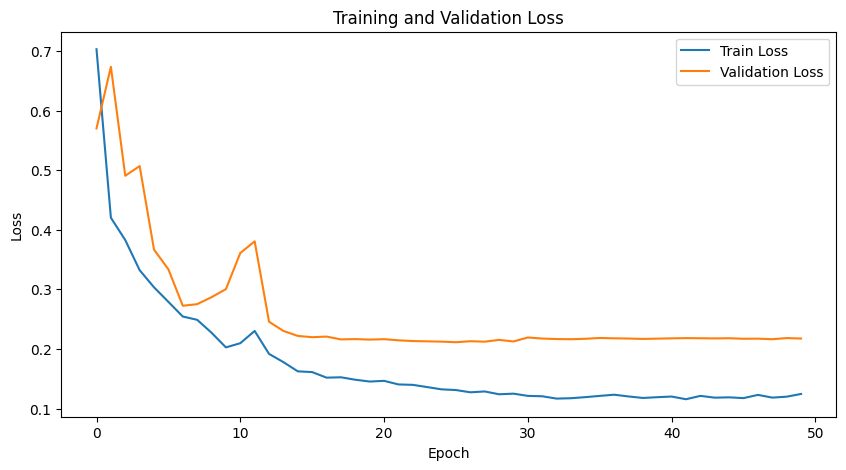

In [16]:
# 학습 손실 및 검증 손실 시각화
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# 손실 시각화
plot_losses(train_losses, val_losses)

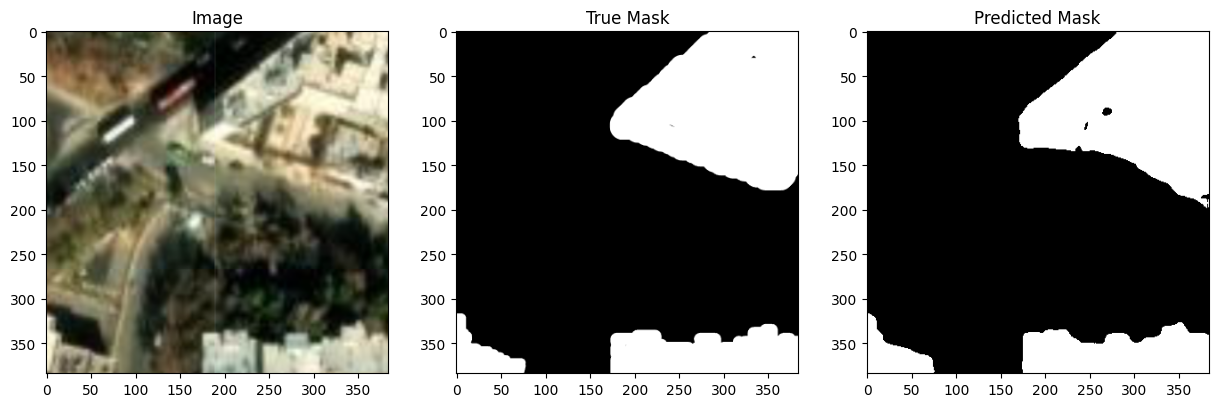

In [17]:
# 이미지와 마스크를 시각화하는 함수 (역정규화 포함)
# 이미지와 마스크를 시각화하는 함수 (역정규화 포함)
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_comparison(image, true_mask, pred_mask, mean, std):
    # Denormalize the image for visualization
    image = denormalize(image, mean, std)
    image = image.permute(1, 2, 0).cpu().numpy()  # 채널을 마지막으로 배치하고 numpy 배열로 변환
    true_mask = true_mask.cpu().numpy()
    pred_mask = pred_mask.squeeze().cpu().numpy()  # 채널 차원을 제거하여 (224, 224) 형태로 변환

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)  # 역정규화된 이미지를 시각화
    ax[0].set_title('Image')
    ax[1].imshow(true_mask, cmap='gray')
    ax[1].set_title('True Mask')
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    plt.show()
    
# 특정 인덱스에서 이미지와 마스크 가져오기
def get_image_and_mask_at_index(dataset, index):
    image, mask = dataset[index]
    return image, mask

# 모델을 평가 모드로 전환
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# 검증 데이터셋의 특정 인덱스
index = 1  # 원하는 인덱스로 변경
image, mask = get_image_and_mask_at_index(val_dataset, index)


# 모델로 마스크 추론
with torch.no_grad():
    image = image.float().to(device).unsqueeze(0)  # 배치 차원을 추가
    mask = mask.float().to(device).unsqueeze(0)
    mask = mask / 255  # 마스크를 0과 1로 변환

    output = model(image)
    pred = torch.sigmoid(output)  # Sigmoid activation to get probability
    pred = (pred > 0.5).float()  # Binarize the outputs at 0.5 threshold

# 첫 번째 이미지와 마스크를 시각화
visualize_comparison(image.squeeze(0), mask.squeeze(0), pred.squeeze(0), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))